In [69]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from climatetranslation.unit.data import get_all_data_loaders, CustomTransformer
from climatetranslation.unit.utils import get_config

In [70]:
conf = get_config("/home/dfulu/repos/climateTranslation/climatetranslation/unit/configs/v4_example.yaml")
conf

{'image_save_iter': 10000,
 'image_display_iter': 100,
 'display_size': 16,
 'snapshot_save_iter': 10000,
 'log_iter': 10,
 'max_iter': 1000000,
 'batch_size': 1,
 'weight_decay': 0.0001,
 'beta1': 0.5,
 'beta2': 0.999,
 'init': 'kaiming',
 'lr': 0.0001,
 'lr_policy': 'step',
 'step_size': 100000,
 'gamma': 0.5,
 'gan_w': 1,
 'recon_x_w': 10,
 'recon_h_w': 0,
 'recon_kl_w': 0.01,
 'recon_x_cyc_w': 10,
 'recon_kl_cyc_w': 0.01,
 'vgg_w': 0,
 'gen': {'dim': 64,
  'mlp_dim': 256,
  'style_dim': 8,
  'activ': 'relu',
  'n_downsample': 2,
  'n_res': 4,
  'pad_type': 'zero',
  'output_activ': ['relu', 'none', 'none', 'none']},
 'dis': {'dim': 64,
  'norm': 'none',
  'activ': 'lrelu',
  'n_layer': 4,
  'gan_type': 'lsgan',
  'num_scales': 3,
  'pad_type': 'reflect'},
 'num_workers': 5,
 'data_zarr_a': '/datadrive/hadgem3/nat_hist_zarr',
 'data_zarr_b': '/datadrive/cam5/nat_hist_zarr',
 'agg_data_a': '/datadrive/hadgem3/nat_hist_agg.nc',
 'agg_data_b': '/datadrive/cam5/nat_hist_agg.nc',
 'prepr

# Check for reasonable looking results when loaded
- [x] units
- [x] zeromean
- [x] normalise
- [x] custom_nofield
- [x] custom_allfield
- [x] custom_tasfield
- [ ] custom_prfield

In [4]:
# units
conf['preprocess_method'] = 'custom_tasfield' # [units, zeromean, normalise, custom_nofield, custom_allfield, custom_tasfield, custom_prfield]

In [5]:
loaders = get_all_data_loaders(conf)

Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Have a look at individual samples of preprocessed data and the time means

In [6]:
ds = loaders[0].dataset.ds.isel(time=np.arange(0,9000, 11), run=0).compute()

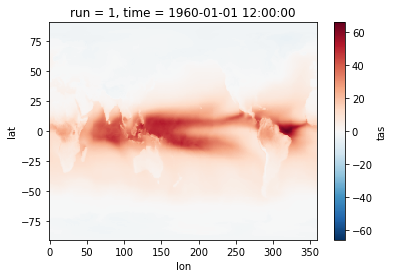

In [7]:
ds.tas.isel(time=0).plot()

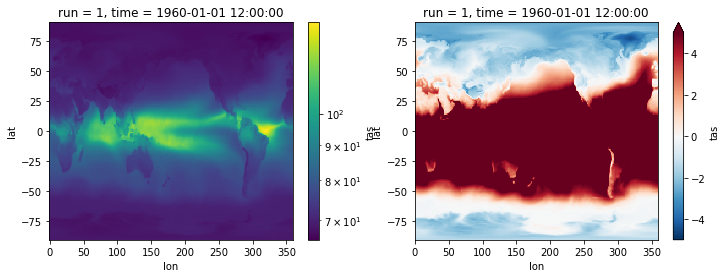

In [24]:
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(121)
(ds.tas.isel(time=0)+70).plot(norm=colors.LogNorm())
plt.subplot(122)
ds.tas.isel(time=0).plot(norm=colors.Normalize(vmin=-5, vmax=5))

For the temperature above data, processed as Temp_K$_{ij}$ -> (Temp_K$_{ij}$ -273.15)/$\sigma_{ij}$, it looks like a bad transform. However, you have to remember that the network will be looking for differences between the predicted and real values. The real values have unit variance even if the means are very different. This method of preprocessing means 0 degress Celcius is given a value of 0 after preprocessing globally and stops the poles, which have higher variance, dominating the errors.

On the other hand, the convolutional filters may have some trouble dealing with how spatially inhomogeneous the transform makes this. So either of `custom_tasfield` or `custom_nofield` could be best.

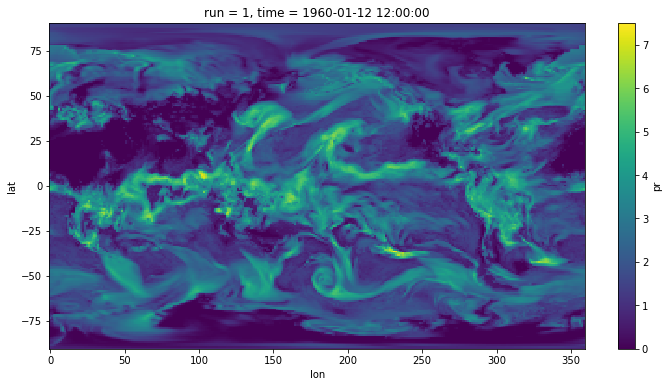

In [8]:
plt.figure(figsize=(12,6))
ds.pr.isel(time=1).plot()

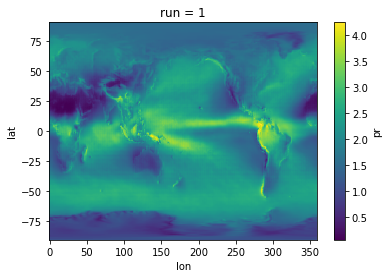

In [9]:
ds.pr.mean(dim='time').plot()

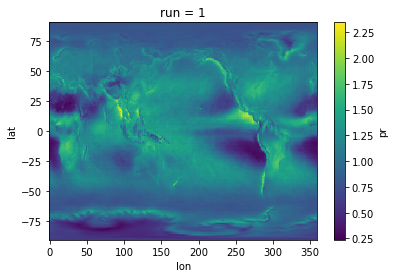

In [10]:
ds.pr.std(dim='time').plot()

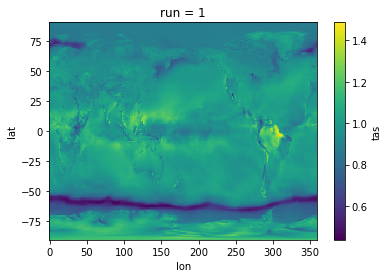

In [11]:
ds.tas.std(dim='time').plot()

# Check for ability to translate back

In [25]:
# units
conf['preprocess_method'] = 'custom_tasfield' # [units, zeromean, normalise, custom_nofield, custom_allfield, custom_tasfield, custom_prfield]
loaders = get_all_data_loaders(conf)

if conf['preprocess_method']=='zeromean':
    trans = ZeroMeaniser(conf, downscale_consolidate=True)
elif conf['preprocess_method']=='normalise':
    trans = Normaliser(conf, downscale_consolidate=True)
elif conf['preprocess_method']=='units':
    trans = UnitModifier(conf, downscale_consolidate=True)
elif conf['preprocess_method']=='custom_allfield':
    trans = CustomTransformer(conf, downscale_consolidate=True, tas_field_norm=True, pr_field_norm=True)
elif conf['preprocess_method']=='custom_tasfield':
    trans = CustomTransformer(conf, downscale_consolidate=True, tas_field_norm=True, pr_field_norm=False)
elif conf['preprocess_method']=='custom_prfield':
    trans = CustomTransformer(conf, downscale_consolidate=True, tas_field_norm=False, pr_field_norm=True)
elif conf['preprocess_method']=='custom_nofield':
    trans = CustomTransformer(conf, downscale_consolidate=True, tas_field_norm=False, pr_field_norm=False)
else:
    raise ValueError(f"Unrecognised preprocess_method : {conf['preprocess_method']}")

ds_a = loaders[0].dataset.ds.isel(time=1, run=0).compute()
ds_b = loaders[2].dataset.ds.isel(time=1, run=0).compute()
    
trans.fit(trans.ds_agg_a, trans.ds_agg_b)

Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "
/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))


Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


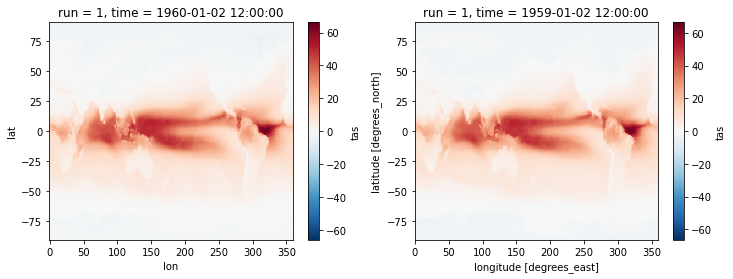

In [26]:
# preprocessed data
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
ds_a.tas.plot(ax=ax)
ax = plt.subplot(122)
ds_b.tas.plot(ax=ax)

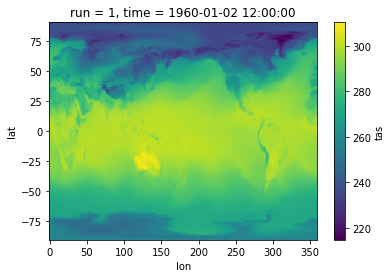

In [27]:
# de-processed data
trans.inverse_a(ds_a).tas.plot()

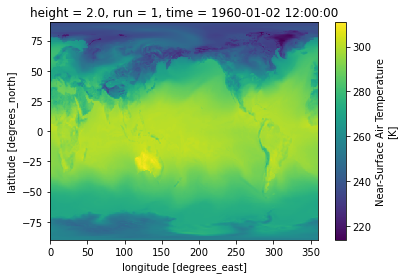

In [28]:
# original data
xr.open_zarr(conf['data_zarr_a']).isel(time=1, run=0, height=1).tas.plot()

## Test full train loading scheme

In [1]:
from climatetranslation.unit.utils import prepare_sub_folder, write_html, write_loss, get_config, write_2images, Timer
from climatetranslation.unit.data import get_all_data_loaders

import os
import sys
import shutil

import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import tensorboardX


# replace the argparser in original
class blank:
    pass

opts = blank()
opts.config = '/home/dfulu//repos/climateTranslation/climatetranslation/unit/configs/hadgem3_to_cam5_nat-hist-v4.yaml'
opts.output_path = '/home/dfulu/tmp'
opts.resume = False

cudnn.benchmark = True

# Load experiment setting
config = get_config(opts.config)

display_size = 2 #config['display_size']
config['batch_size'] = 1
config['preprocess_method'] = 'custom_nofield' # works : 'normalise', 'units' no-works: 'custom_allfield'

# data loaders
train_loader_a, test_loader_a, train_loader_b, test_loader_b = get_all_data_loaders(config, downscale_consolidate=True)

Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [2]:
# Selection of climate fields to display after a number of updates
def generate_n(generator, n):
    return torch.cat([img for _, img in zip(range((n-1)//generator.batch_size + 1), generator)])[:n]

train_display_images_a = generate_n(train_loader_a, display_size).cuda()
train_display_images_b = generate_n(train_loader_b, display_size).cuda()
test_display_images_a  = generate_n(test_loader_a, display_size).cuda()
test_display_images_b  = generate_n(test_loader_b, display_size).cuda()

In [3]:
def examine(imgs):
    return torch.isnan(imgs).any().item(), imgs.max().item(), imgs.min().item()

print('set    ', 'isnan, max, min')
print('train a', examine(train_display_images_a))
print('train b', examine(train_display_images_b))
print('test  a', examine(test_display_images_a))
print('test  b', examine(test_display_images_b))

set     isnan, max, min
train a (False, 9.417543411254883, -11.536054611206055)
train b (False, 7.4095139503479, -13.816139221191406)
test  a (False, 8.210234642028809, -10.866368293762207)
test  b (False, 7.985375881195068, -12.878362655639648)
